In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset
df = pd.read_csv("career.csv")

In [2]:
# Display first few rows
df.head()

,Skills,Experience Level,Education Level,Personal Interests,Job Market Demand Score,Corrected Recommendation
0,AWS,Senior,High School,Technology,10.0,Cloud Engineer
1,DevOps,Mid,Master's,Data Science & Analytics,10.0,DevOps Engineer
2,JavaScript,Entry,Bachelor's,Artificial Intelligence & Machine Learning,8.0,Web Developer
3,PHP,Mid,Ph.D.,Cloud Computing & DevOps,10.0,Web Developer
4,TypeScript,Entry,Bachelor's,Gaming & Game Development,1.0,Web Developer


In [3]:
#dataset overview
df.shape

(1910, 6)

In [4]:
# Show basic statistics
df.describe()

,Job Market Demand Score
count,1900.000000
mean,5.486316
std,2.857014
min,1.000000
25%,3.000000
50%,5.000000
75%,8.000000
max,10.000000


In [5]:
# Check for missing values
df.isnull().sum()

Skills                      10
Experience Level            10
Education Level             10
Personal Interests          10
Job Market Demand Score     10
Corrected Recommendation    10
dtype: int64

In [6]:
df["Skills"].fillna("", inplace=True)
df.dropna(subset=["Experience Level", "Education Level", "Personal Interests", "Job Market Demand Score"], inplace=True)


## Expolatory Data Analysis (EDA)

In [7]:
#Visualize Career Recommendation Distribution

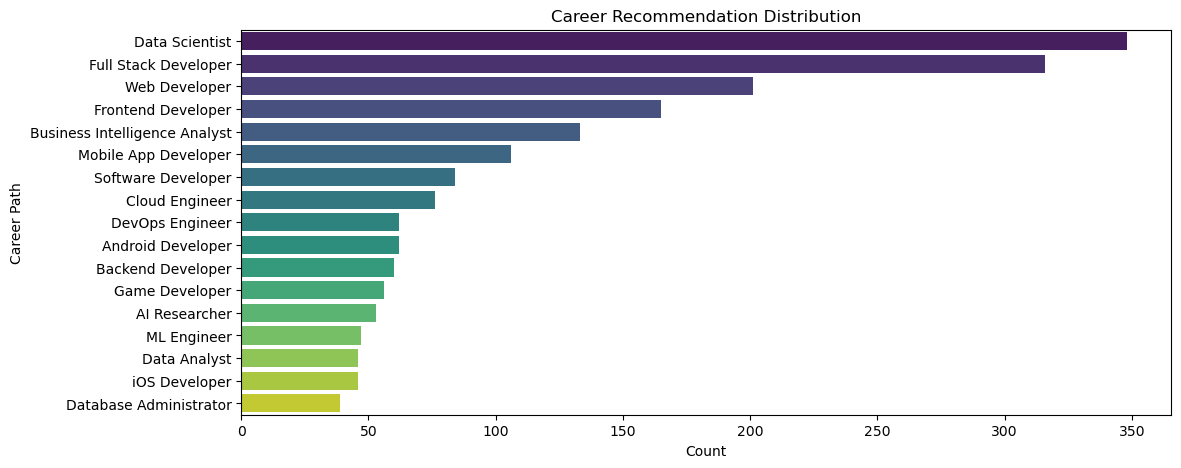

In [8]:
plt.figure(figsize=(12, 5))
sns.countplot(y=df["Corrected Recommendation"], order=df["Corrected Recommendation"].value_counts().index, palette="viridis")
plt.title("Career Recommendation Distribution")
plt.xlabel("Count")
plt.ylabel("Career Path")
plt.show()


In [9]:
#Visualize Experience and Education Levels

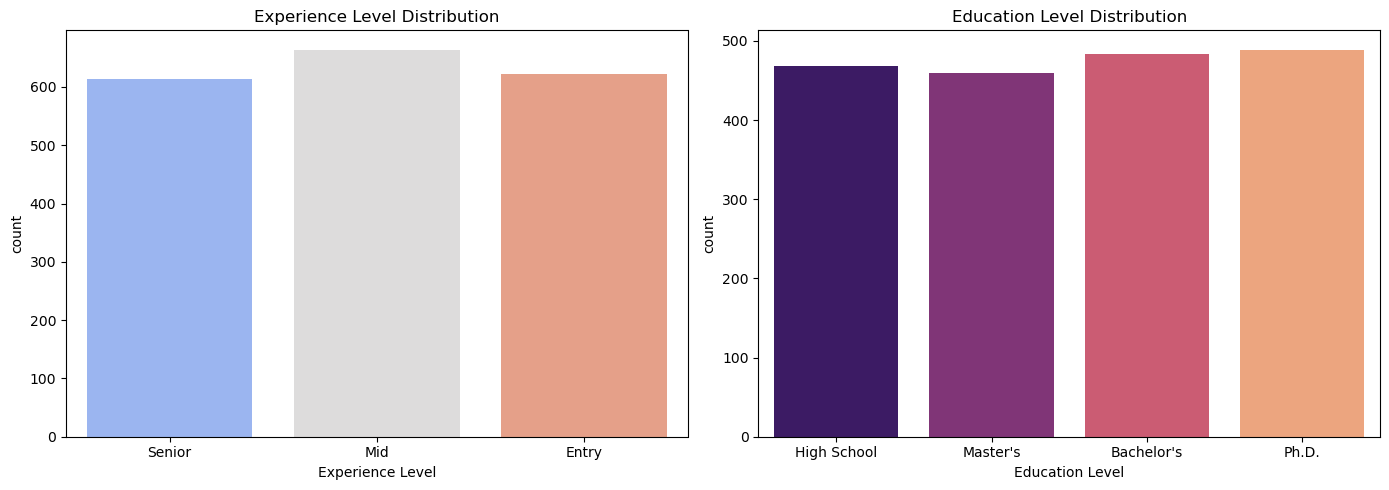

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(x=df["Experience Level"], palette="coolwarm", ax=axes[0])
axes[0].set_title("Experience Level Distribution")

sns.countplot(x=df["Education Level"], palette="magma", ax=axes[1])
axes[1].set_title("Education Level Distribution")

plt.tight_layout()
plt.show()


In [11]:
#Encode Categorical Variables

In [12]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in ["Experience Level", "Education Level", "Personal Interests","Corrected Recommendation"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store for later use






In [13]:
# Apply TF-IDF on Skills

In [14]:
# Fill NaN values in the "Skills" column with an empty string or placeholder
df["Skills"].fillna('', inplace=True)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
skills_tfidf = tfidf.fit_transform(df["Skills"])


In [15]:
#Normalize Job Market Demand Score

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df["Job Market Demand Score"] = scaler.fit_transform(df[["Job Market Demand Score"]])


### Train Machine Learning Model

Train-Test Split and Model Training

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import hstack

# Prepare features and target
X = hstack([skills_tfidf, df[["Experience Level", "Education Level", "Personal Interests", "Job Market Demand Score"]].values])
y = df["Corrected Recommendation"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

#### Model Evaluation

In [18]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Predictions
y_pred = model.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred)*100)

# Classification Report
y_test_classes = np.unique(y_test)
print("Classification Report:\n", classification_report(y_test, y_pred, labels=y_test_classes))


Accuracy: 83.42105263157895
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.93      1.00      0.97        14
           2       1.00      1.00      1.00        11
           3       0.91      0.88      0.89        24
           4       1.00      0.86      0.92        14
           5       0.50      0.20      0.29        10
           6       0.73      0.80      0.76        74
           7       0.88      1.00      0.93         7
           8       0.85      1.00      0.92        11
           9       1.00      1.00      1.00        36
          10       0.78      0.84      0.81        68
          11       0.38      0.71      0.50         7
          12       1.00      1.00      1.00         3
          13       0.84      0.55      0.67        29
          14       0.85      0.65      0.73        17
          15       0.92      0.92      0.92        39
          16       0.86      

#### Career Prediction Function

In [33]:
def predict_top_careers(skills, experience, education, interests, job_demand, top_n=3, accuracy_threshold=0.0):
    # Process Inputs
    skills_vectorized = tfidf.transform([skills])
    experience_encoded = label_encoders["Experience Level"].transform([experience])
    education_encoded = label_encoders["Education Level"].transform([education])
    interests_encoded = label_encoders["Personal Interests"].transform([interests])
    job_demand_scaled = scaler.transform([[job_demand]])

    # Combine Features
    input_data = hstack([skills_vectorized, [[experience_encoded[0], education_encoded[0], interests_encoded[0], job_demand_scaled[0][0]]]])

    # Predict Career Probabilities
    probabilities = model.predict_proba(input_data)[0]
    top_indices = np.argsort(probabilities)[-top_n:][::-1]

    # Filter results with probability greater than the accuracy threshold
    filtered_results = [
        (le.inverse_transform([idx])[0], probabilities[idx])
        for idx in top_indices if probabilities[idx] > accuracy_threshold
    ]

    return filtered_results

# Example usage
print(predict_top_careers("SQL", "Mid", "Bachelor's", "Technology", 9))


[('Database Administrator', 0.98), ('Game Developer', 0.01), ('Data Scientist', 0.01)]


C:\Users\PMLS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
# export the model

In [32]:
import joblib

# Save the model
joblib.dump(model, 'career_prediction_model.pkl')


['career_prediction_model.pkl']

### Other Models Evaluation

In [ ]:
# # decision tree
# from sklearn.model_selection import train_test_split
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import accuracy_score, classification_report
# from scipy.sparse import hstack
# import numpy as np

# # Prepare features and target
# X = hstack([skills_tfidf, df[["Experience Level", "Education Level", "Personal Interests", "Job Market Demand Score"]].values])
# y = df["Corrected Recommendation"]

# # Train-Test Split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train Decision Tree Model
# model = DecisionTreeClassifier(random_state=42)
# model.fit(X_train, y_train)

# # Predictions
# y_pred = model.predict(X_test)

# # Accuracy
# print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred) * 100)


In [ ]:
# #knn
# from sklearn.model_selection import train_test_split
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import accuracy_score, classification_report
# from scipy.sparse import hstack
# import numpy as np

# # Prepare features and target
# X = hstack([skills_tfidf, df[["Experience Level", "Education Level", "Personal Interests", "Job Market Demand Score"]].values])
# y = df["Corrected Recommendation"]

# # Train-Test Split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train K-Nearest Neighbors Model
# model = KNeighborsClassifier(n_neighbors=5)
# model.fit(X_train, y_train)

# # Predictions
# y_pred = model.predict(X_test)

# # Accuracy
# print("K-Nearest Neighbors Accuracy:", accuracy_score(y_test, y_pred) * 100)


In [ ]:
# #support vector Machine
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score, classification_report
# from scipy.sparse import hstack
# import numpy as np

# # Prepare features and target
# X = hstack([skills_tfidf, df[["Experience Level", "Education Level", "Personal Interests", "Job Market Demand Score"]].values])
# y = df["Corrected Recommendation"]

# # Train-Test Split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train Support Vector Machine Model
# model = SVC(probability=True, random_state=42)
# model.fit(X_train, y_train)

# # Predictions
# y_pred = model.predict(X_test)

# # Accuracy
# print("Support Vector Machine Accuracy:", accuracy_score(y_test, y_pred) * 100)


In [ ]:
# #logistic regression
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, classification_report
# from scipy.sparse import hstack
# import numpy as np

# # Prepare features and target
# X = hstack([skills_tfidf, df[["Experience Level", "Education Level", "Personal Interests", "Job Market Demand Score"]].values])
# y = df["Corrected Recommendation"]

# # Train-Test Split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train Logistic Regression Model
# model = LogisticRegression(max_iter=1000, random_state=42)
# model.fit(X_train, y_train)

# # Predictions
# y_pred = model.predict(X_test)

# # Accuracy
# print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred) * 100)
